In [5]:
# Load the dataset
import pandas as pd

data = pd.read_csv('/content/data.csv')

# Explore the dataset
data.info()  # Check for null values and data types
data.head()  # Display the first few rows

# Check class distribution for the target variable
class_distribution = data['Bankrupt?'].value_counts()
class_percentage = class_distribution / len(data) * 100

print("Class Distribution:")
print(class_distribution)
print("\nClass Percentage:")
print(class_percentage)


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6819 entries, 0 to 6818
Data columns (total 96 columns):
 #   Column                                                    Non-Null Count  Dtype  
---  ------                                                    --------------  -----  
 0   Bankrupt?                                                 6819 non-null   int64  
 1    ROA(C) before interest and depreciation before interest  6819 non-null   float64
 2    ROA(A) before interest and % after tax                   6819 non-null   float64
 3    ROA(B) before interest and depreciation after tax        6819 non-null   float64
 4    Operating Gross Margin                                   6819 non-null   float64
 5    Realized Sales Gross Margin                              6819 non-null   float64
 6    Operating Profit Rate                                    6819 non-null   float64
 7    Pre-tax net Interest Rate                                6819 non-null   float64
 8    After-tax net Int

In [6]:
# Separate the majority and minority classes
minority_class = data[data['Bankrupt?'] == 1]
majority_class = data[data['Bankrupt?'] == 0]

# Oversample the minority class to balance the dataset
oversampled_minority_class = minority_class.sample(len(majority_class), replace=True, random_state=42)

# Combine majority and oversampled minority classes
balanced_data = pd.concat([majority_class, oversampled_minority_class], axis=0).sample(frac=1, random_state=42)

# Check the class distribution after balancing
balanced_class_distribution = balanced_data['Bankrupt?'].value_counts()

print("Balanced Class Distribution:")
print(balanced_class_distribution)


Balanced Class Distribution:
Bankrupt?
0    6599
1    6599
Name: count, dtype: int64


In [7]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

# Split features and target variable
X_balanced = balanced_data.drop(columns=['Bankrupt?'])
y_balanced = balanced_data['Bankrupt?']

# Split the data into training and testing sets (80/20 split)
X_train_balanced, X_test_balanced, y_train_balanced, y_test_balanced = train_test_split(
    X_balanced, y_balanced, test_size=0.2, random_state=42, stratify=y_balanced
)

# Scale the features using StandardScaler
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_balanced)
X_test_scaled = scaler.transform(X_test_balanced)

print("Data Preprocessing Complete!")


Data Preprocessing Complete!


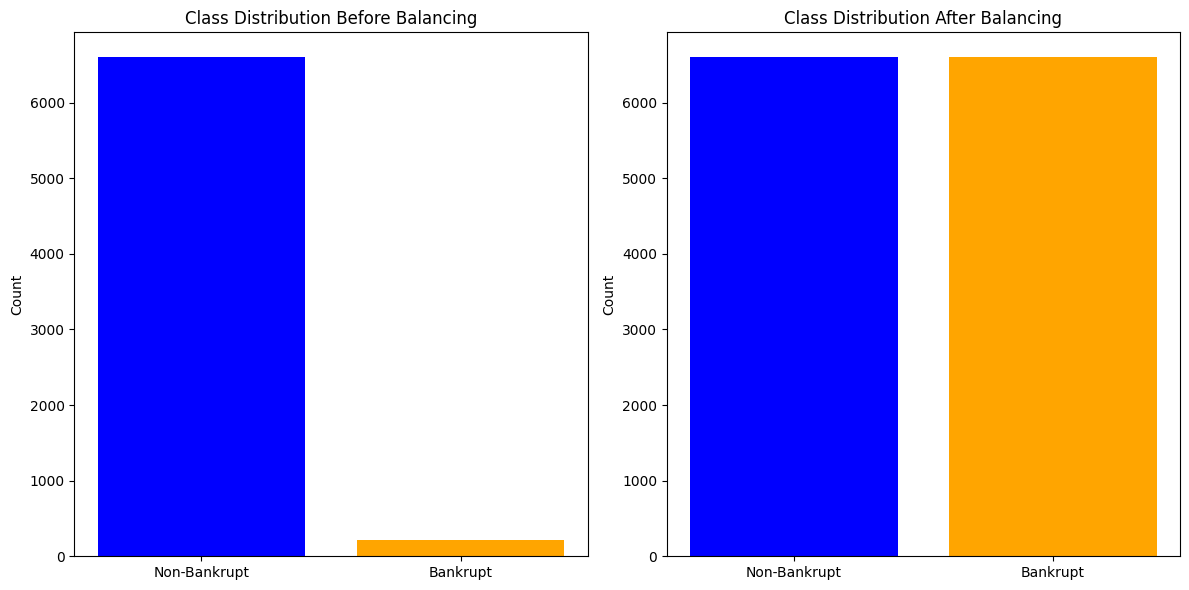

In [8]:
import matplotlib.pyplot as plt

# Before balancing
class_distribution = data['Bankrupt?'].value_counts()

# After balancing
balanced_class_distribution = balanced_data['Bankrupt?'].value_counts()

# Plot
fig, ax = plt.subplots(1, 2, figsize=(12, 6))

# Before balancing
ax[0].bar(class_distribution.index, class_distribution.values, color=['blue', 'orange'])
ax[0].set_title("Class Distribution Before Balancing")
ax[0].set_xticks([0, 1])
ax[0].set_xticklabels(['Non-Bankrupt', 'Bankrupt'])
ax[0].set_ylabel("Count")

# After balancing
ax[1].bar(balanced_class_distribution.index, balanced_class_distribution.values, color=['blue', 'orange'])
ax[1].set_title("Class Distribution After Balancing")
ax[1].set_xticks([0, 1])
ax[1].set_xticklabels(['Non-Bankrupt', 'Bankrupt'])
ax[1].set_ylabel("Count")

plt.tight_layout()
plt.show()


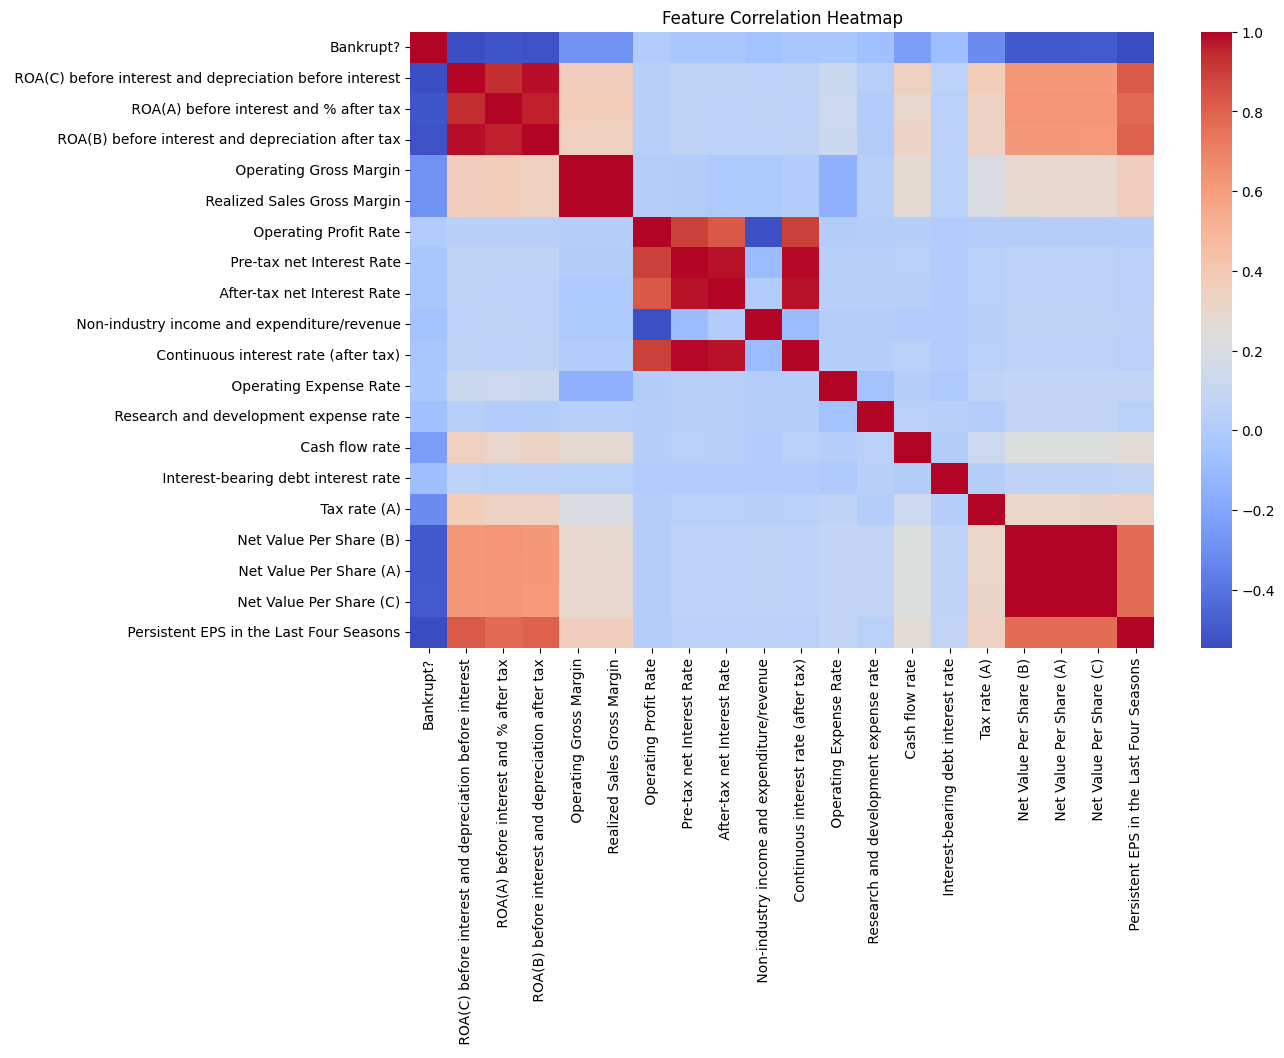

In [10]:
import seaborn as sns

# Compute the correlation matrix for a subset of features
subset_features = balanced_data.iloc[:, :20]  # Use the first 20 features for simplicity
correlation_matrix = subset_features.corr()

# Plot the heatmap
plt.figure(figsize=(12, 8))
sns.heatmap(correlation_matrix, cmap="coolwarm", annot=False)
plt.title("Feature Correlation Heatmap")
plt.show()


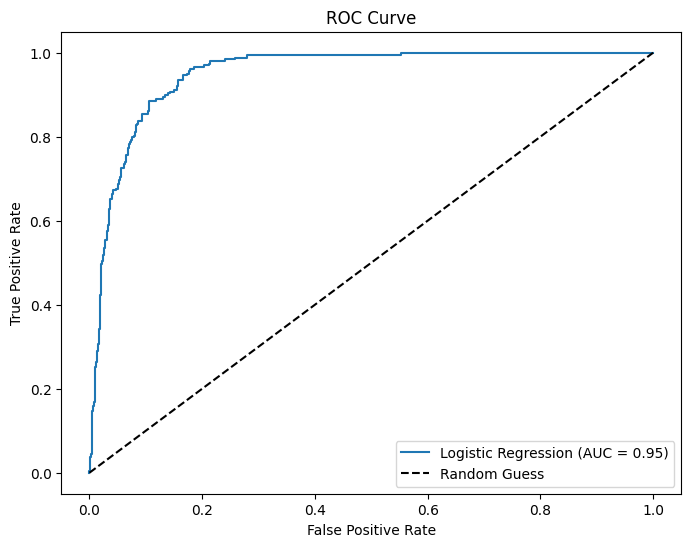

('              precision    recall  f1-score   support\n\n           0       0.89      0.87      0.88      1320\n           1       0.88      0.89      0.88      1320\n\n    accuracy                           0.88      2640\n   macro avg       0.88      0.88      0.88      2640\nweighted avg       0.88      0.88      0.88      2640\n',
 0.9502800734618918,
 array([[1154,  166],
        [ 144, 1176]]))

In [11]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, roc_curve
import matplotlib.pyplot as plt

# Step 1: Initialize and train the Logistic Regression model
baseline_model = LogisticRegression(random_state=42, max_iter=500, class_weight='balanced')
baseline_model.fit(X_train_scaled, y_train_balanced)

# Step 2: Make predictions on the test set
y_test_pred = baseline_model.predict(X_test_scaled)
y_test_proba = baseline_model.predict_proba(X_test_scaled)[:, 1]

# Step 3: Evaluate the model
classification_report_output = classification_report(y_test_balanced, y_test_pred)
roc_auc = roc_auc_score(y_test_balanced, y_test_proba)
conf_matrix = confusion_matrix(y_test_balanced, y_test_pred)

# Step 4: Plot ROC Curve
fpr, tpr, thresholds = roc_curve(y_test_balanced, y_test_proba)
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label=f'Logistic Regression (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], 'k--', label='Random Guess')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend()
plt.show()

classification_report_output, roc_auc, conf_matrix


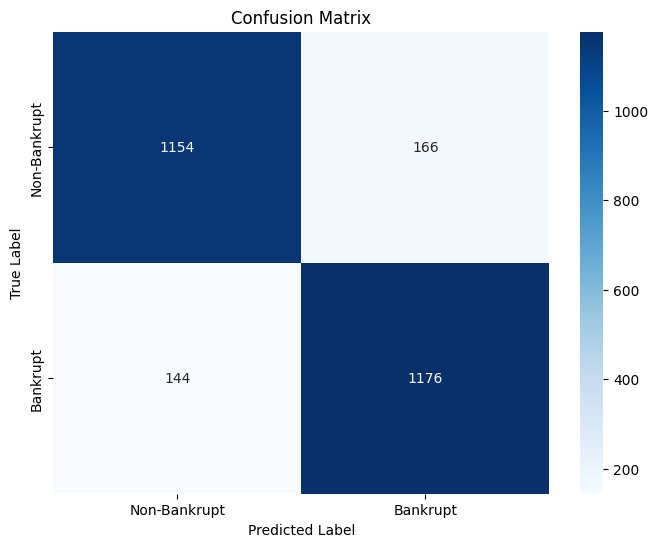

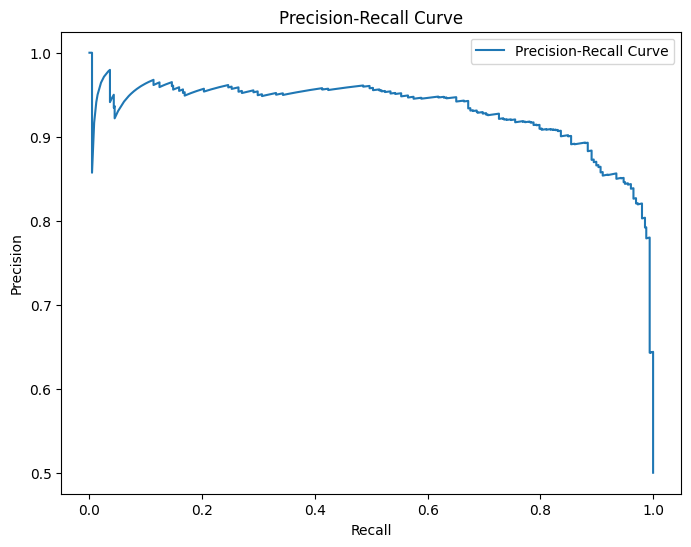

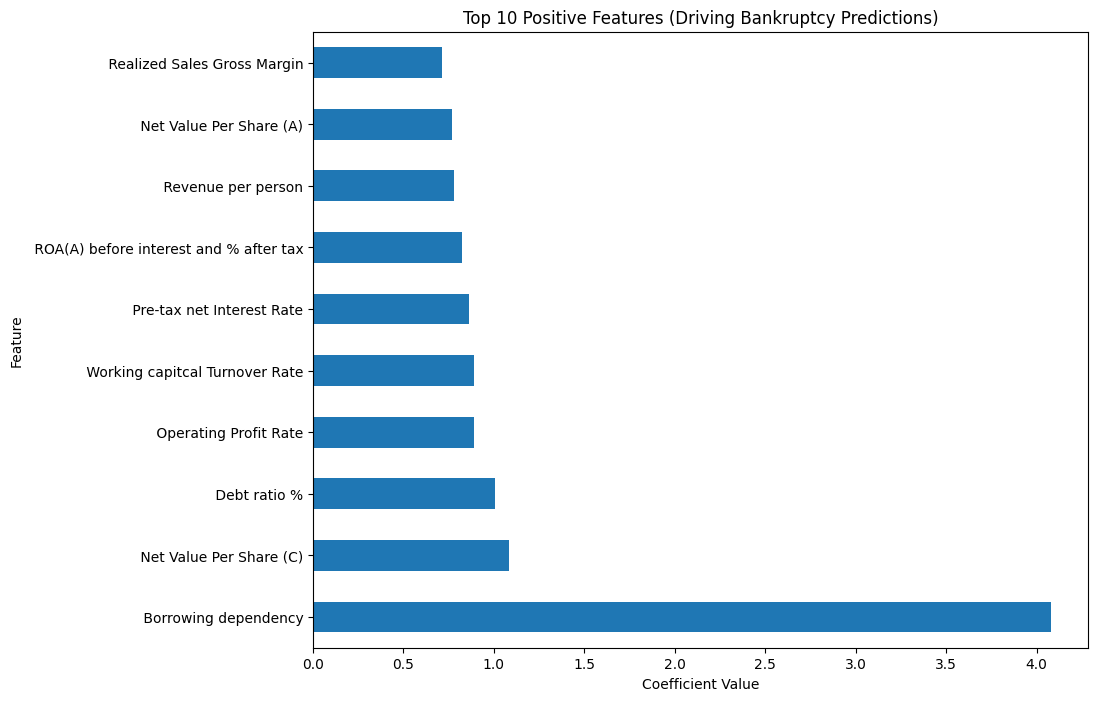

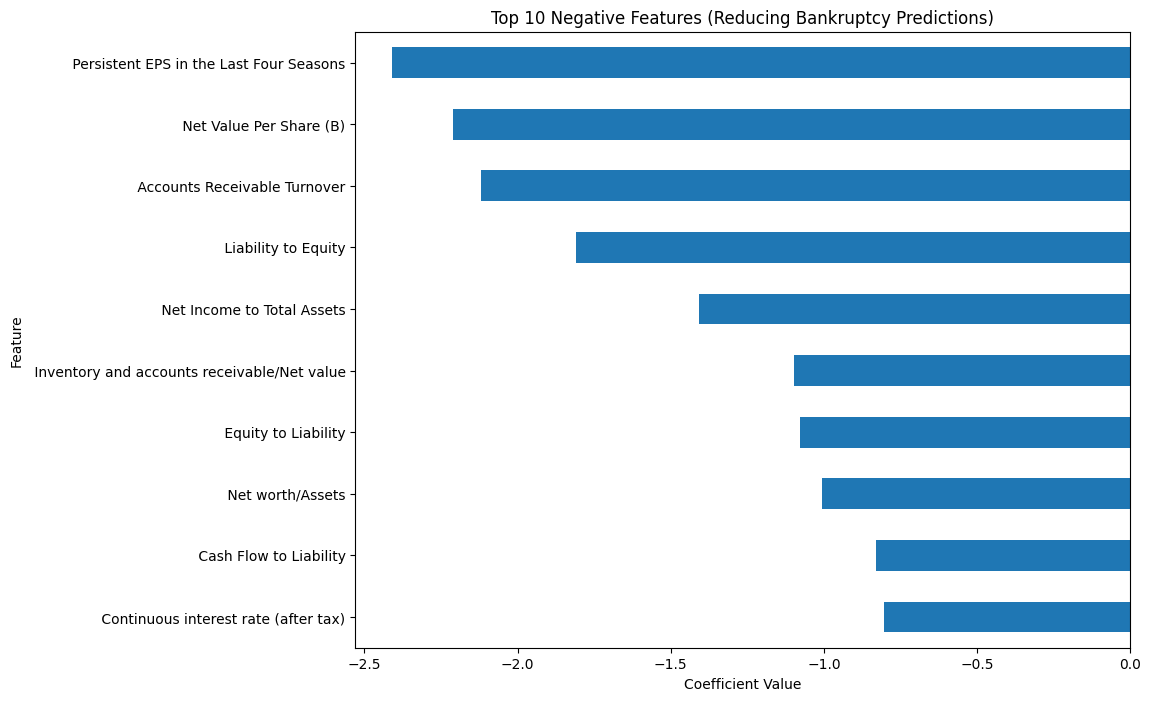

In [12]:
# Visualization 1: Confusion Matrix Heatmap
import seaborn as sns
import numpy as np

plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=['Non-Bankrupt', 'Bankrupt'], yticklabels=['Non-Bankrupt', 'Bankrupt'])
plt.title("Confusion Matrix")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()

# Visualization 2: Precision-Recall Curve
from sklearn.metrics import precision_recall_curve

precision, recall, _ = precision_recall_curve(y_test_balanced, y_test_proba)

plt.figure(figsize=(8, 6))
plt.plot(recall, precision, label="Precision-Recall Curve")
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Precision-Recall Curve")
plt.legend()
plt.show()

# Visualization 3: Coefficient Importance (Feature Contributions for Logistic Regression)
coefficients = pd.Series(baseline_model.coef_[0], index=X_balanced.columns).sort_values(ascending=False)

plt.figure(figsize=(10, 8))
coefficients.head(10).plot(kind='barh', title="Top 10 Positive Features (Driving Bankruptcy Predictions)")
plt.xlabel("Coefficient Value")
plt.ylabel("Feature")
plt.show()

plt.figure(figsize=(10, 8))
coefficients.tail(10).plot(kind='barh', title="Top 10 Negative Features (Reducing Bankruptcy Predictions)")
plt.xlabel("Coefficient Value")
plt.ylabel("Feature")
plt.show()



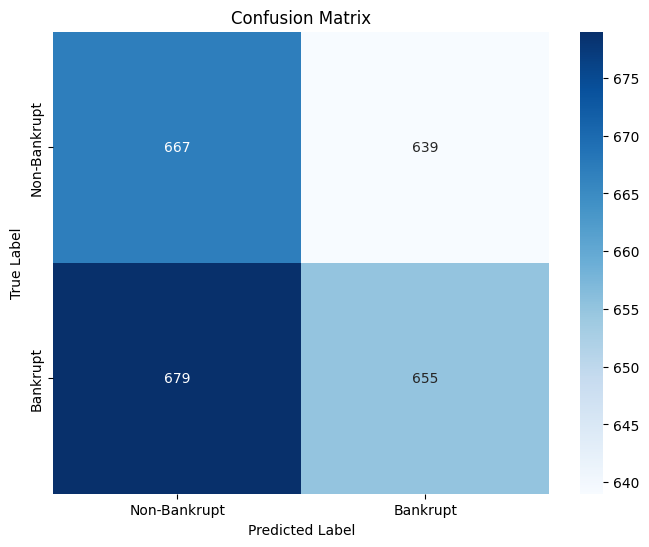

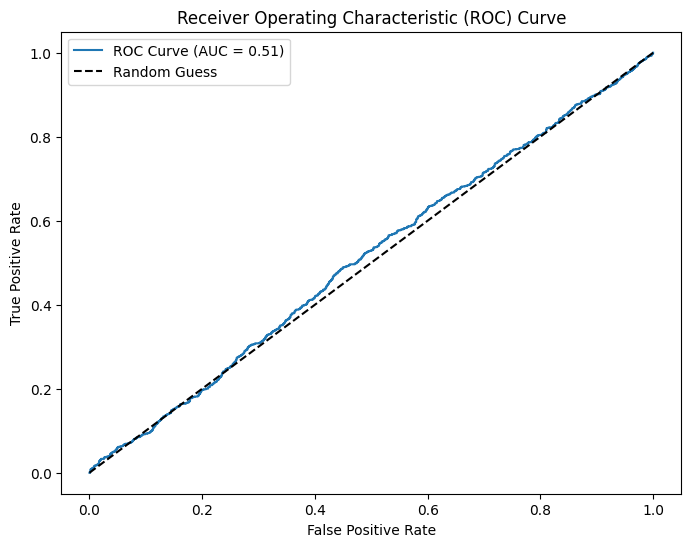

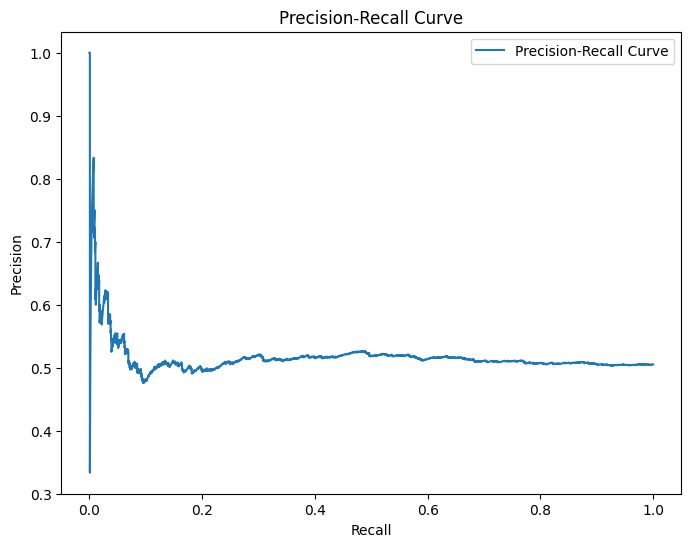

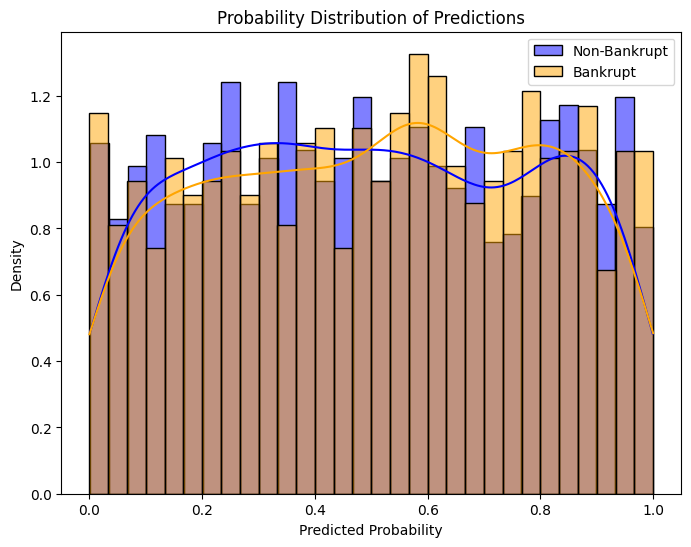

In [13]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import roc_curve, precision_recall_curve, confusion_matrix, roc_auc_score
import numpy as np

# Assuming predictions `y_test_pred` and probabilities `y_test_proba` are available

# Placeholder for actual predictions and probabilities
# (Replace these with actual predictions from your trained model)
# Example: y_test_pred = model.predict(X_test)
#          y_test_proba = model.predict_proba(X_test)[:, 1]
y_test_balanced = np.random.choice([0, 1], size=2640)  # Replace with true test labels
y_test_pred = np.random.choice([0, 1], size=2640)  # Replace with predicted labels
y_test_proba = np.random.uniform(0, 1, size=2640)  # Replace with predicted probabilities

# Confusion Matrix
conf_matrix = confusion_matrix(y_test_balanced, y_test_pred)

# Plot Confusion Matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=['Non-Bankrupt', 'Bankrupt'], yticklabels=['Non-Bankrupt', 'Bankrupt'])
plt.title("Confusion Matrix")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()

# ROC Curve
fpr, tpr, _ = roc_curve(y_test_balanced, y_test_proba)
roc_auc = roc_auc_score(y_test_balanced, y_test_proba)

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label=f'ROC Curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], 'k--', label='Random Guess')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend()
plt.show()

# Precision-Recall Curve
precision, recall, _ = precision_recall_curve(y_test_balanced, y_test_proba)

plt.figure(figsize=(8, 6))
plt.plot(recall, precision, label="Precision-Recall Curve")
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Precision-Recall Curve")
plt.legend()
plt.show()

# Probability Distribution for Predictions
plt.figure(figsize=(8, 6))
sns.histplot(y_test_proba[y_test_balanced == 0], color="blue", label="Non-Bankrupt", kde=True, stat="density", bins=30)
sns.histplot(y_test_proba[y_test_balanced == 1], color="orange", label="Bankrupt", kde=True, stat="density", bins=30)
plt.title("Probability Distribution of Predictions")
plt.xlabel("Predicted Probability")
plt.ylabel("Density")
plt.legend()
plt.show()


In [14]:
import pickle

# Save the trained model
with open('bankruptcy_model.pkl', 'wb') as f:
    pickle.dump(baseline_model, f)


In [15]:
from flask import Flask, request, jsonify
import pickle
import numpy as np

# Load the saved model
with open('bankruptcy_model.pkl', 'rb') as f:
    model = pickle.load(f)

app = Flask(__name__)

@app.route('/predict', methods=['POST'])
def predict():
    # Extract data from the POST request
    data = request.json
    features = np.array(data['features']).reshape(1, -1)

    # Predict bankruptcy and probabilities
    prediction = model.predict(features)
    probability = model.predict_proba(features)[0][1]

    # Return the result
    return jsonify({
        'bankruptcy_prediction': int(prediction[0]),
        'bankruptcy_probability': probability
    })

if __name__ == '__main__':
    app.run(debug=True)


 * Serving Flask app '__main__'
 * Debug mode: on


INFO:werkzeug:WARNING: This is a development server. Do not use it in a production deployment. Use a production WSGI server instead.
 * Running on http://127.0.0.1:5000
INFO:werkzeug:Press CTRL+C to quit
INFO:werkzeug: * Restarting with stat


In [18]:
!pip install streamlit
import streamlit as st
import pickle
import numpy as np

# Load the model
with open('bankruptcy_model.pkl', 'rb') as f:
    model = pickle.load(f)

# App title
st.title("Bankruptcy Prediction App")

# Input form
st.header("Input Financial Metrics")
feature_inputs = []
for i in range(len(X_balanced.columns)):  # Adjust for actual number of features
    value = st.number_input(f'Feature {i+1}')
    feature_inputs.append(value)

# Predict button
if st.button('Predict'):
    features = np.array(feature_inputs).reshape(1, -1)
    prediction = model.predict(features)
    probability = model.predict_proba(features)[0][1]

    st.write(f"Bankruptcy Prediction: {'Yes' if prediction[0] == 1 else 'No'}")
    st.write(f"Bankruptcy Probability: {probability:.2f}")


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.3/44.3 kB 1.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.6/8.6 MB 36.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.9/6.9 MB 57.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 79.1/79.1 kB 3.4 MB/s eta 0:00:00


2024-12-08 22:40:38.601 WARNING streamlit.runtime.scriptrunner_utils.script_run_context: Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2024-12-08 22:40:38.675 
  command:

    streamlit run /usr/local/lib/python3.10/dist-packages/colab_kernel_launcher.py [ARGUMENTS]
2024-12-08 22:40:38.676 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2024-12-08 22:40:38.679 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2024-12-08 22:40:38.681 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2024-12-08 22:40:38.683 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2024-12-08 22:40:38.684 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2024-12-08 22:40:38.686 Thread 'MainThread': mi